# Stationary data tests for time series forecasting

* Ref: [https://pythondata.com/stationary-data-tests-for-time-series-forecasting/](https://pythondata.com/stationary-data-tests-for-time-series-forecasting/)
* Data: [https://github.com/urgedata/pythondata/blob/master/Autoregression/DEOK_hourly.csv](https://github.com/urgedata/pythondata/blob/master/Autoregression/DEOK_hourly.csv)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (15, 5)
# plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

## 1. Load data

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/DEOK_hourly.csv')
df.head()

,Datetime,DEOK_MW
0,2012-12-31 01:00:00,2945.0
1,2012-12-31 02:00:00,2868.0
2,2012-12-31 03:00:00,2812.0
3,2012-12-31 04:00:00,2812.0
4,2012-12-31 05:00:00,2860.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57739 entries, 0 to 57738
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  57739 non-null  object 
 1   DEOK_MW   57739 non-null  float64
dtypes: float64(1), object(1)
memory usage: 902.3+ KB


In [ ]:
# Change the Datetime type to datetime and set it as row index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df.head()

,DEOK_MW
Datetime,
2012-12-31 01:00:00,2945.0
2012-12-31 02:00:00,2868.0
2012-12-31 03:00:00,2812.0
2012-12-31 04:00:00,2812.0
2012-12-31 05:00:00,2860.0


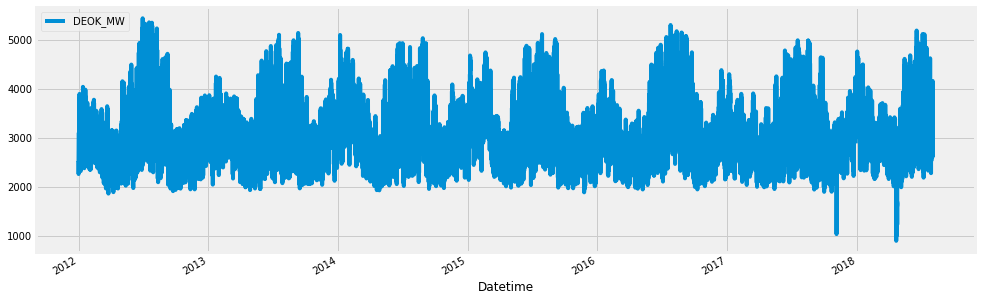

In [ ]:
# Make plot to see the time series distribution
fig, ax = plt.subplots(figsize=(15, 5))
df.plot(ax=ax)
plt.show()

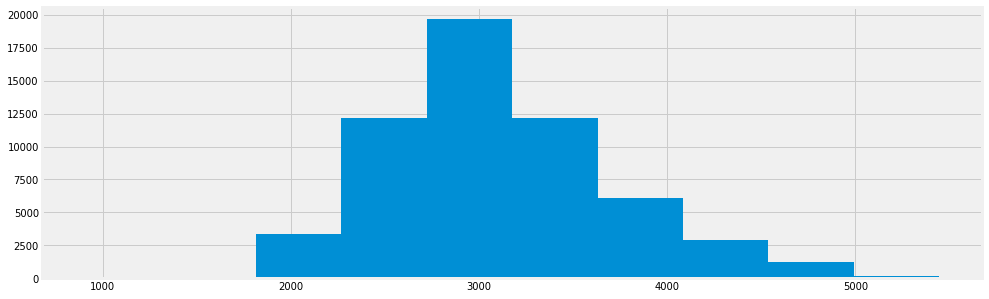

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
df['DEOK_MW'].hist(ax=ax)
plt.show()

From the plots, the data distribution looks stationary. We can split data into many pieces and check the mean and variance for each piece. If the mean and variance in all pieces are similiar, then the data distribution can be said it is stationary.

In [ ]:
length = len(df['DEOK_MW'])
piece1, piece2, piece3 = np.split(df['DEOK_MW'].sample(frac=1), 
                                  [int(0.25 * length), int(0.75 * length)])
# piece2 = 0.25% of piece1
# piece3 = 0.75% of piece1

mean1 = piece1.mean()
mean2 = piece2.mean()
mean3 = piece3.mean()

var1 = piece1.var()
var2 = piece2.var()
var3 = piece3.var()

print(mean1, mean2, mean3)
print(var1, var2, var3)

3117.463973950395 3103.087183927953 3096.748458607551
365445.119224449 356596.68514870765 360504.660776862


## 2. Analysis
* Check the correlation
* Check the stationarity
    * Dickey-Fuller test:
        * null hypothesis: unit root exists in time series $\to$ i.e. time series is non-stationary
        * p-value > 0.05: non stationary
        * p-value < 0.05: stationary (reject null hypothesis)
        * ADF < 0

### Check the correlation
        

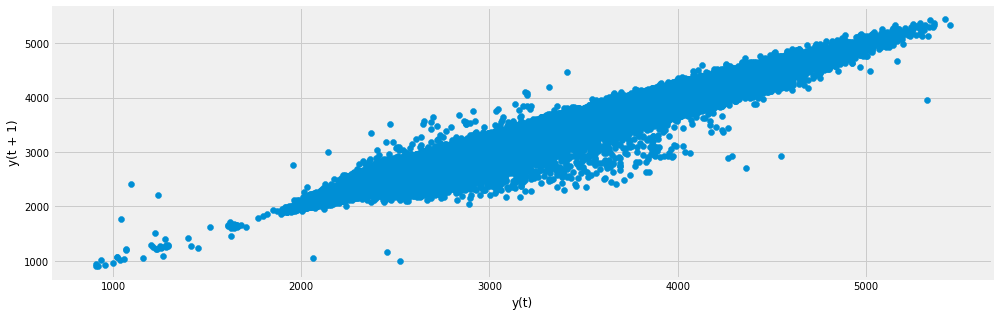

In [ ]:
# Use lag_plot() to check the correlation between time steps
fig, ax = plt.subplots(figsize=(15, 5))
pd.plotting.lag_plot(df['DEOK_MW'], ax=ax)
plt.show()

From the `lag_plot()`, we do see the correlations existing

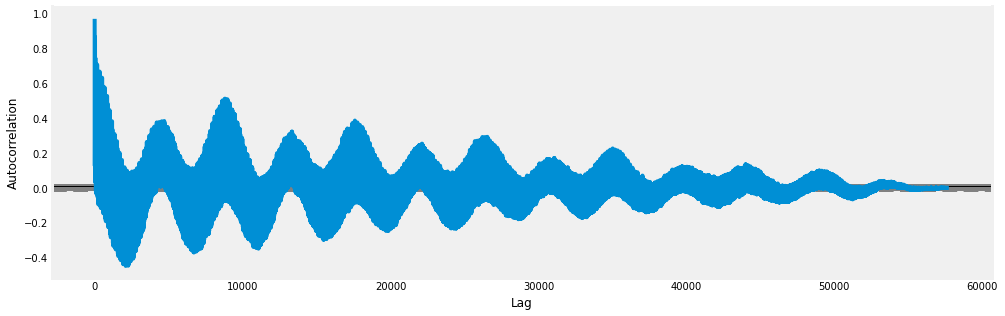

In [ ]:
# Use autocorrelation_plot() to check correlations
fig, ax = plt.subplots(figsize=(15, 5))
pd.plotting.autocorrelation_plot(df['DEOK_MW'], ax=ax)
plt.show()

Let's zoom in the plot. The first time the red curve touching the 95% confidence level is about lag=80

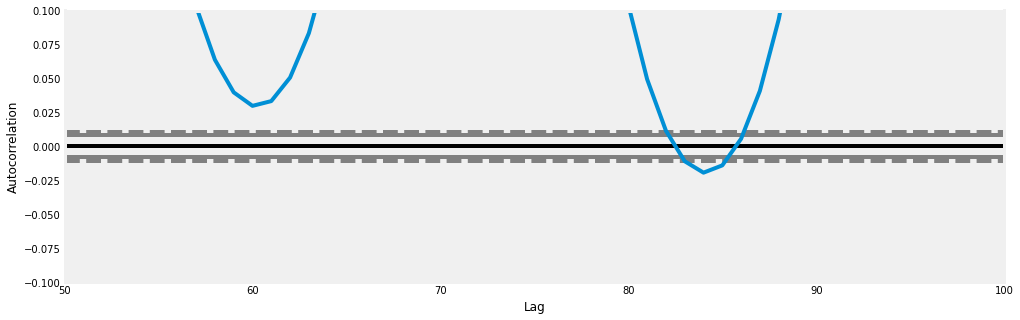

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
pd.plotting.autocorrelation_plot(df['DEOK_MW'], ax=ax)
ax.set_xlim((50, 100))
ax.set_ylim((-0.1, 0.1))
plt.show()

### Check the stationarity

In [ ]:
# Run augmented dickey-fuller test
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['DEOK_MW'])

print(adf_test)
print(f'ADF={adf_test[0]}, p-value={adf_test[1]}')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(-14.91326780106981, 1.4477674072054197e-27, 57, 57681, {'1%': -3.4304633751328555, '5%': -2.86159010962736, '10%': -2.5667966716717614}, 669611.2391196273)
ADF=-14.91326780106981, p-value=1.4477674072054197e-27


## 3. Forecast

In [ ]:
# Create train and test dataset
X = df['DEOK_MW'].dropna()
print(len(X), type(X), X)

# We want to predict the last 12 data points
train = X[1 : len(X) - 12]
test = X[len(X)-12:] # 只預測最後一年份每個月的結果
print(len(train), type(train), train)
print(len(test), type(test), test)

57739 <class 'pandas.core.series.Series'> Datetime
2012-12-31 01:00:00    2945.0
2012-12-31 02:00:00    2868.0
2012-12-31 03:00:00    2812.0
2012-12-31 04:00:00    2812.0
2012-12-31 05:00:00    2860.0
                        ...  
2018-01-01 20:00:00    4426.0
2018-01-01 21:00:00    4419.0
2018-01-01 22:00:00    4355.0
2018-01-01 23:00:00    4224.0
2018-01-02 00:00:00    4100.0
Name: DEOK_MW, Length: 57739, dtype: float64
57726 <class 'pandas.core.series.Series'> Datetime
2012-12-31 02:00:00    2868.0
2012-12-31 03:00:00    2812.0
2012-12-31 04:00:00    2812.0
2012-12-31 05:00:00    2860.0
2012-12-31 06:00:00    2957.0
                        ...  
2018-01-01 08:00:00    3994.0
2018-01-01 09:00:00    3978.0
2018-01-01 10:00:00    3950.0
2018-01-01 11:00:00    3924.0
2018-01-01 12:00:00    3917.0
Name: DEOK_MW, Length: 57726, dtype: float64
12 <class 'pandas.core.series.Series'> Datetime
2018-01-01 13:00:00    3865.0
2018-01-01 14:00:00    3824.0
2018-01-01 15:00:00    3766.0
2018-01-01

In [ ]:
# Train the autogression model
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score

model = AR(train)
model_fitted = model.fit()

print(f'The lag value chose is: {model_fitted.k_ar}')
print(f'The coefficients of the model are:\n {model_fitted.params}')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The lag value chose is: 59
The coefficients of the model are:
 const          38.520219
L1.DEOK_MW      1.247731
L2.DEOK_MW     -0.257936
L3.DEOK_MW     -0.032353
L4.DEOK_MW      0.012451
L5.DEOK_MW     -0.020541
L6.DEOK_MW     -0.007894
L7.DEOK_MW     -0.014966
L8.DEOK_MW     -0.003535
L9.DEOK_MW      0.001031
L10.DEOK_MW     0.007951
L11.DEOK_MW     0.001185
L12.DEOK_MW    -0.004225
L13.DEOK_MW     0.008298
L14.DEOK_MW    -0.010909
L15.DEOK_MW    -0.006333
L16.DEOK_MW    -0.008469
L17.DEOK_MW    -0.023109
L18.DEOK_MW     0.013685
L19.DEOK_MW     0.031637
L20.DEOK_MW     0.017318
L21.DEOK_MW    -0.014597
L22.DEOK_MW     0.000299
L23.DEOK_MW     0.056054
L24.DEOK_MW     0.502758
L25.DEOK_MW    -0.631612
L26.DEOK_MW     0.067366
L27.DEOK_MW     0.036809
L28.DEOK_MW     0.012704
L29.DEOK_MW     0.014211
L30.DEOK_MW     0.010074
L31.DEOK_MW    -0.002744
L32.DEOK_MW    -0.023109
L33.DEOK_MW     0.013091
L34.DEOK_MW     0.012413
L35.DEOK_MW     0.001017
L36.DEOK_MW     0.008098
L37.DEOK_MW 

In [ ]:
# Prediction
start=len(train)
end=len(train) + len(test) - 1 # 一次就預測最後一年每個月的結果 \hat{y}(t+1), ..., \hat{y}(t+12)
print(f'start={start}, end={end}')

predictions = model_fitted.predict(start=start, end=end, dynamic=False)
print(predictions)

start=57726, end=57737
57726    3869.472137
57727    3805.973745
57728    3796.575978
57729    3797.108515
57730    3890.598661
57731    4097.286867
57732    4260.151854
57733    4310.203028
57734    4307.501185
57735    4252.261197
57736    4146.984356
57737    4053.067806
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Since the predictions doens't have index, we have to use the index from the original dataset

In [ ]:
index = df[['DEOK_MW']].tail(12).index

In [ ]:
df_compare = pd.DataFrame({'actual': test.values,
                           'predicted': predictions.values},
                          index=index)
df_compare

,actual,predicted
Datetime,,
2018-01-01 13:00:00,3865.0,3869.472137
2018-01-01 14:00:00,3824.0,3805.973745
2018-01-01 15:00:00,3766.0,3796.575978
2018-01-01 16:00:00,3776.0,3797.108515
2018-01-01 17:00:00,3885.0,3890.598661
2018-01-01 18:00:00,4200.0,4097.286867
2018-01-01 19:00:00,4393.0,4260.151854
2018-01-01 20:00:00,4426.0,4310.203028
2018-01-01 21:00:00,4419.0,4307.501185


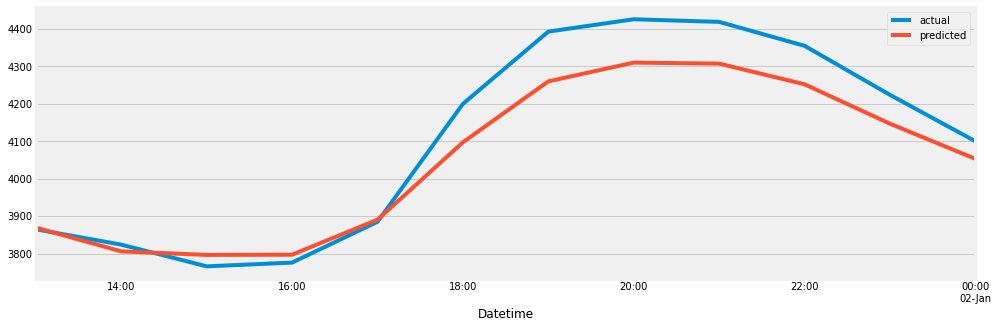

In [ ]:
# Make plot to compare the actual and predicted values
fig, ax = plt.subplots(figsize=(15, 5))
df_compare.plot(ax=ax)
plt.show()

In [ ]:
# Goodness of prediction
from sklearn.metrics import r2_score
r2 = r2_score(df['DEOK_MW'].tail(12), predictions)
r2

0.9043037349364104